<a href="https://colab.research.google.com/github/adifatol/BIQA/blob/master/convNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [23]:
!ls blur

1600.BLUR.1.png		   log_seaside.BLUR.1.png
1600.BLUR.2.png		   log_seaside.BLUR.2.png
1600.BLUR.3.png		   log_seaside.BLUR.3.png
1600.BLUR.4.png		   log_seaside.BLUR.4.png
1600.BLUR.5.png		   log_seaside.BLUR.5.png
aerial_city.BLUR.1.png	   monument.BLUR.1.png
aerial_city.BLUR.2.png	   monument.BLUR.2.png
aerial_city.BLUR.3.png	   monument.BLUR.3.png
aerial_city.BLUR.4.png	   monument.BLUR.4.png
aerial_city.BLUR.5.png	   monument.BLUR.5.png
boston.BLUR.1.png	   native_american.BLUR.1.png
boston.BLUR.2.png	   native_american.BLUR.2.png
boston.BLUR.3.png	   native_american.BLUR.3.png
boston.BLUR.4.png	   native_american.BLUR.4.png
boston.BLUR.5.png	   native_american.BLUR.5.png
bridge.BLUR.1.png	   redwood.BLUR.1.png
bridge.BLUR.2.png	   redwood.BLUR.2.png
bridge.BLUR.3.png	   redwood.BLUR.3.png
bridge.BLUR.4.png	   redwood.BLUR.4.png
bridge.BLUR.5.png	   redwood.BLUR.5.png
butter_flower.BLUR.1.png   roping.BLUR.1.png
butter_flower.BLUR.2.png   roping.BLUR.2.png
butter_flower.BLUR.3.png 

# Upload Images

shows a dialog to upload new images

option to download the CSIQ Image Quality Database

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [25]:
import os

if not (
  os.path.exists("blur") and
  os.path.exists("contrast") and
  os.path.exists("jpeg") and
  os.path.exists("jpeg2000") and
  os.path.exists("fnoise")
):
  !wget http://vision.eng.shizuoka.ac.jp/csiq/src_imgs.zip
  !wget http://vision.eng.shizuoka.ac.jp/csiq/dst_imgs.zip

  !unzip -n src_imgs.zip
  !unzip -n dst_imgs.zip
else:
  print("images found, skipping.")

images found, skipping.


# Load Images in colab

loads images of a certain SHAPE into runtime memory

In [26]:

import os

# List Image Names
# Parses each file name of format <NAME>.png
# TODO: support for other extensions?
def image_list( ext = '.png'):
  names = {}
  for f in [file for file in os.listdir() if file.endswith(ext)]:
    fname = os.path.splitext(f)[0]
    names[fname] = 1
  return list(names.keys())

img_list = image_list()
print('Images found: ', img_list)

Images found:  ['cactus', 'child_swimming', 'elk', 'fisher', '1600', 'butter_flower', 'geckos', 'sunset_sparrow', 'log_seaside', 'veggies', 'trolley', 'native_american', 'shroom', 'turtle', 'couple', 'swarm', 'roping', 'aerial_city', 'redwood', 'foxy', 'lake', 'woman', 'sunsetcolor', 'family', 'snow_leaves', 'bridge', 'boston', 'monument', 'rushmore', 'lady_liberty']


Nr of img: 10


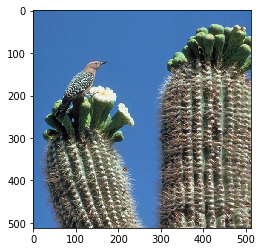

In [124]:

# Load the images
# Encode them into jpg

DISTORT = ['blur','contrast','fnoise', 'jpeg', 'jpeg2000']
DISTORT_EXT = ['BLUR','contrast','fnoise', 'JPEG', 'jpeg2000']
Q_LEVELS = ['1','2','3','4','5']
NR_IMG = 10

from random import randint
import numpy as np
import cv2

#TODO support for nItems = 'ALL'
#TODO support various loading order (randomize?)
def load_imgs(img_list, nItems):
  images = {}
  images['orig'] = []
  for dist in DISTORT:
    images[dist] = {}
    for qlvl in Q_LEVELS:
      images[dist][qlvl] = []

  for f in range(0,nItems):
    fname = img_list[f]
    original = fname+'.png'
    img_data = cv2.imread(original)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    images['orig'].append(img_data)
    for dist, d_ext in zip(DISTORT, DISTORT_EXT):
      for qlvl in Q_LEVELS:
        f_path = dist+'/'+fname+'.'+d_ext+'.'+qlvl+'.png'
        img_data = cv2.imread(f_path)
        img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
        images[dist][qlvl].append(img_data)
  return images

images = load_imgs(img_list, NR_IMG)

print("Nr of img:",len(images['orig']))


In [0]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_all(arr_of_images, patch_estimator=False):
  columns = 5
  spacing = 14.75
  minorLocator = MultipleLocator(spacing)
  fig = plt.figure(figsize=(20,10))
  for i, image in enumerate(arr_of_images):
    ax = fig.add_subplot(len(images) / columns + 1, columns, i + 1)
    if patch_estimator:
      ax.yaxis.set_minor_locator(minorLocator)
      ax.xaxis.set_minor_locator(minorLocator)
      ax.grid(which = 'minor')
    plt.imshow(image)
  plt.show()


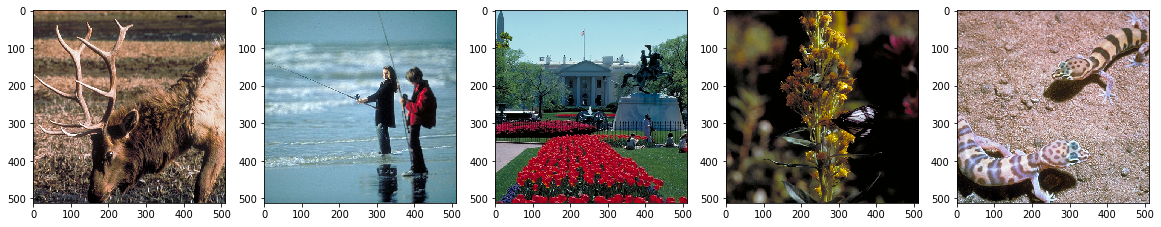

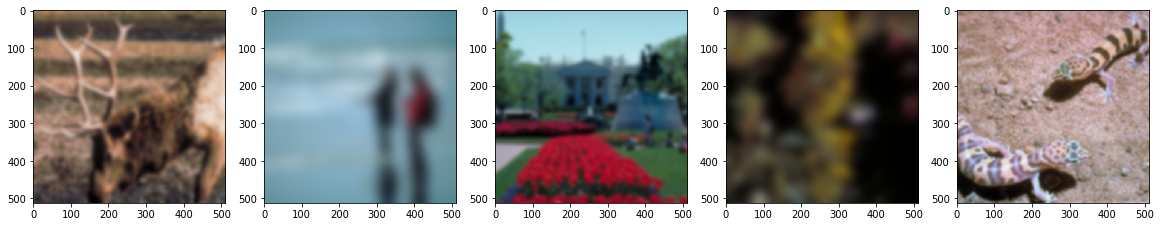

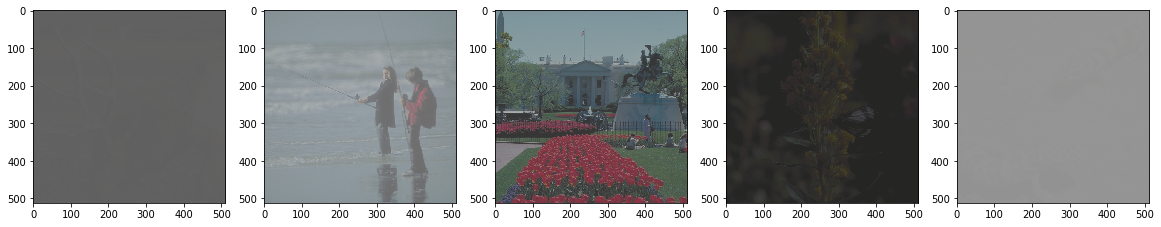

In [29]:
#Print some stats
max_to_show = min(NR_IMG,5)
rand_idx = randint(0, len(images['orig'])-max_to_show)
plot_all(images['orig'][rand_idx:rand_idx+max_to_show])
plot_all(images['blur']['5'][rand_idx:rand_idx+max_to_show])
plot_all(images['contrast']['5'][rand_idx:rand_idx+max_to_show])


# Score Images

apply the method suggested in [Learning without Human Scores for Blind Image Quality Assessment](https://www.cv-foundation.org/openaccess/content_cvpr_2013/papers/Xue_Learning_without_Human_2013_CVPR_paper.pdf)

## Extract Patches and calculate {SSIM} score

In [30]:
!pip install tqdm

In [141]:
#Calculate the number of patches


OWH = 512 # 512 x 512
WH = 15 #
WINDOW_SHAPE = (WH,WH,3)
PATCH_COUNT = int(int(OWH / WH) * int(OWH / WH))

print(PATCH_COUNT)

1156


In [142]:
from skimage.measure import compare_ssim
from skimage.util.shape import view_as_windows
from tqdm import tqdm

def plot_patches(patches):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 1
  rows = 1
  for i in range(1, columns*rows +1):
      img = patches[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

def extract_patches(img):
  patches = np.squeeze(view_as_windows(img, WINDOW_SHAPE,step=WH))
  patches = np.reshape(patches,(-1,WH,WH,3))
  patches = np.sum(patches/3, axis=3, keepdims=True)
  return patches

dim_len, dim_dist, dim_q = len(images['orig']), len(DISTORT), len(Q_LEVELS);
test_len = dim_len

one_score = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
scores = [np.copy(one_score) for x in range(test_len)]
all_patches = []

for i in tqdm(range(len(images['orig'][:test_len]))):
  img = images['orig'][i]
  orig_patches = extract_patches(img)
  for idist, dist in enumerate(DISTORT):
    for iqlvl, qlvl in enumerate(Q_LEVELS):
      dist_img = images[dist][qlvl][i]
      distorted_patches = extract_patches(dist_img)
      local_scores = np.zeros(PATCH_COUNT)
      local_patches = []
      for j in range(PATCH_COUNT):
        orig_patch = orig_patches[j]
        dist_patch = distorted_patches[j]
        (score, diff) = compare_ssim(orig_patch, dist_patch, full=True, multichannel=True)
        local_scores[j] = score
        all_patches.append(dist_patch)
      scores[i][idist][iqlvl] = np.copy(local_scores)

#   plot_patches(orig_patches)
#   for patch in orig_patches:
#   (score, diff) = compare_ssim(dist_img, img, full=True, multichannel=True)
#   diff = (diff * 255).astype("uint8")
#   print("___")
#   print("SSIM: {}".format(score))


100%|██████████| 10/10 [01:05<00:00,  6.55s/it]


## Calculate the C constant (![alt text](https://latex.codecogs.com/gif.latex?c%20%3D%20%5Cfrac%7B%5Csum%20_%7Bi%5Cepsilon%20%5COmega%7DS_%7Bi%7D%20%7D%7B10*%5Csum%20_%7Bi%5Cepsilon%20%5COmega_%7Bp%7D%7DS_%7Bi%7D%7D))

In [0]:
def the_C_constant(batch):
  all_sum = sum(batch)
  percentile10 = np.percentile(batch,20)
  omega_p_sum = sum([i for i in batch if i <= percentile10])
  c = all_sum / (10 * omega_p_sum)
  return c
# the_C_constant(scores[0][0][0])

## Histograms for scores

(10, 5, 5, 1156)
4.282341274211198
comparing for 9
(img-9 dist-0 qual-4)
[0.03588364 0.12382757 0.28612695 ... 0.85858196 0.49646743 1.        ]


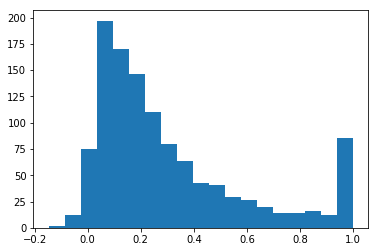

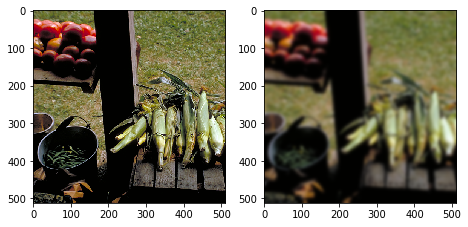

In [158]:
#Random scores visualisations

from mpl_toolkits.mplot3d import Axes3D

def histogram(img_idx, img_dist, img_qual):
  print("comparing for {}".format(img_idx))
  print("(img-{} dist-{} qual-{})".format(img_idx, img_dist, img_qual))
  print(scores[img_idx][img_dist][img_qual])
  plt.hist(scores[img_idx][img_dist][img_qual], bins='auto')
  plt.show()

ri = randint(0,dim_len-1)
rd = randint(0,dim_dist-1)
rq = randint(0,dim_q-1)

print(np.array(scores).shape)

for i in range(ri,ri+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      c = the_C_constant(scores[i][d][q])
      print(c)
      histogram(ri,rd,rq)
      plot_all([images['orig'][i],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])


## Normalize scores

In [0]:
norm_scores = np.copy(scores)
all_scores = []
for i in range(0,dim_len):
  for d in range(0,dim_dist):
    for q in range(0,dim_q):
      c = the_C_constant(scores[i][d][q])
      norm_scores[i][d][q][:] = [x / c for x in norm_scores[i][d][q]]
      all_scores.extend(norm_scores[i][d][q])


(img-9 dist-blur qual-5)


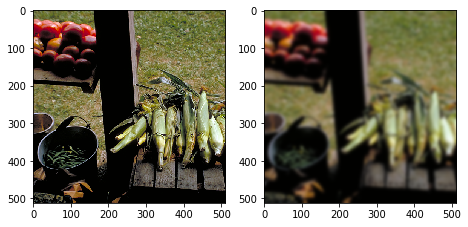

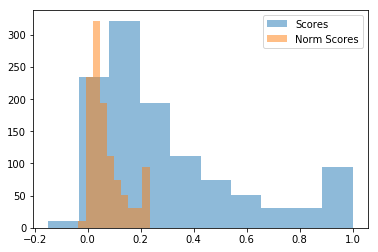

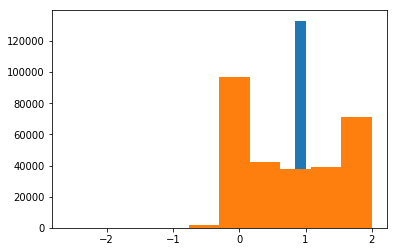

In [160]:
print("(img-{} dist-{} qual-{})".format(ri, DISTORT[rd], Q_LEVELS[rq]))


plot_all([images['orig'][ri],images[DISTORT[rd]][Q_LEVELS[rq]][ri]])

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.legend(loc='upper right')
plt.show()

plt.hist(np.array(scores).flatten())
plt.hist(np.array(norm_scores).flatten())
plt.show()

## Score QAC - Quality Aware Clusters

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
(10, 5, 5, 1156)
(10, 5, 5, 1156)


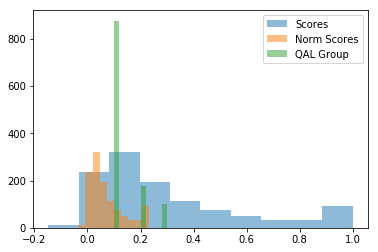

In [161]:
# Define The Score Levels used in QAC

L = 10 # The Score Levels used in QAC
Gl = list(range(1,L+1))
Gl[:] = [x / L for x in Gl]


one_group = [[np.zeros(PATCH_COUNT) for x in range(dim_dist)] for y in range(dim_q)]
G = [np.copy(one_group) for x in range(dim_len)]

print(Gl)
print(np.array(G).shape)
print(np.array(norm_scores).shape)

# for i in range(0,dim_len):
#   for d in range(0,dim_dist):
#     for q in range(0,dim_q):
for i in range(ri,i+1):
  for d in range(rd,rd+1):
    for q in range(rq,rq+1):
      for p,score in enumerate(norm_scores[i][d][q]):
        for score_l in Gl:
          if score <= score_l:
            G[i][d][q][p] = score_l
            break

plt.hist(scores[ri][rd][rq], alpha=0.5, label='Scores')
plt.hist(norm_scores[ri][rd][rq], alpha=0.5, label='Norm Scores')
plt.hist(G[ri][rd][rq], alpha=0.5, label='QAL Group')
plt.legend(loc='upper right')
plt.show()

## Convolutional network with Keras

## High pass filter - Differenceof Gaussian (DoG) ( ![alt text]( https://latex.codecogs.com/gif.latex?h_%7B%5Csigma%20%7D%28r%29%3D1_%7Br%3D0%20%7D-%5Cfrac%7B1%7D%7B%5Csqrt%7B2%5Cpi%20%5Csigma%20%7D%7Dexp%28-%5Cfrac%7Br%5E%7B2%7D%7D%7B2%5Csigma%20%5E%7B2%7D%7D%29) )

In [162]:
from skimage import filters, color

def dog(patch, sigma):
  k = 1.6
  s1 = filters.gaussian(patch,k*sigma)
  s2 = filters.gaussian(patch,sigma)
  # multiply by sigma to get scale invariance
  dog = s1 - s2
  return dog

#Sigmas: [0.2, 2.0, 4.0]

def all_filtered_patches(all_patches, sigma):
  all_filtered = []
  for i in tqdm(range(len(all_patches))):
    patch = all_patches[i]
#     gray_patch = color.rgb2gray(patch)
    gray_patch = patch
    filtered = dog(gray_patch, sigma)
    all_filtered.append(filtered)
  return all_filtered

filtered_02 = all_filtered_patches(all_patches, 0.2)
# filtered_20 = all_filtered_patches(all_patches, 2.0)
# filtered_40 = all_filtered_patches(all_patches, 4.0)

100%|██████████| 289000/289000 [01:01<00:00, 4666.99it/s]


### Split into training and validation

In [163]:
from sklearn.model_selection import train_test_split
from tensorflow import keras 

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(np.array(filtered_02), np.array(all_scores), test_size=0.15, shuffle= False)


num_classes = 10
y_train_c = keras.utils.to_categorical(y_train, num_classes)
y_valid_c = keras.utils.to_categorical(y_valid, num_classes)

print("\ntrain:")
print(np.array(x_train).shape)
print(np.array(y_train).shape)

print("\n y categorical:")
print(np.array(y_train_c).shape)
print(np.array(y_valid_c).shape)

print("\nvalidation:")
print(np.array(x_valid).shape)
print(np.array(y_valid).shape)

print("\nTotal:")
print(np.array(all_patches).shape)
print(np.array(all_scores).shape)


train:
(245650, 15, 15, 1)
(245650,)

 y categorical:
(245650, 10)
(43350, 10)

validation:
(43350, 15, 15, 1)
(43350,)

Total:
(289000, 15, 15, 1)
(289000,)


In [0]:
# # y_train_oh = np.eye(10)[(y_train*L).astype(int)] # L - The Score Levels used in QAC
# # y_valid_oh = np.eye(10)[(y_valid*L).astype(int)] # L - The Score Levels used in QAC

# # y_train_oh = (y_train*L).astype(int)
# # y_valid_oh = (y_valid*L).astype(int)

# # y_train_oh = y_train
# # y_valid_oh = y_valid

# y_train_oh = (y_train*L).astype(int)
# y_valid_oh = (y_valid*L).astype(int)


# # plt.plot(y_train[:10])

# print(y_train_oh.shape)
# print(y_valid_oh.shape)
# print("---------")
# print(x_train.shape)
# print(y_train_oh.shape)
# print(x_valid.shape)
# print(y_valid_oh.shape)
# print(y_train_oh[:10])


# img = np.squeeze(x_train[972]) # 0, 324, 648, 972
# plt.imshow(img)

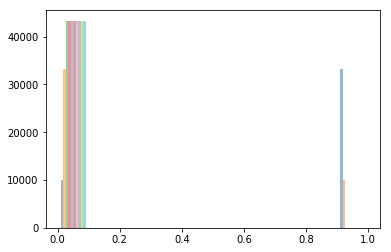

In [164]:
# import tensorflow as tf

# (x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.fashion_mnist.load_data()
# print(x_train.shape)

# x_train = np.expand_dims(x_train, -1)
# x_valid = np.expand_dims(x_valid, -1)

# print(x_train.shape)
# print(y_train.shape)
# print(y_valid.shape)

# plt.hist(y_train_c, alpha=0.5)
plt.hist(y_valid_c, alpha=0.5)
plt.show()

In [118]:
min(y_train)

-0.4679837517361257

### Declare the model

In [165]:
# The model, based on https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=Zo-Yk6LFGfSf
from tensorflow.keras import layers
import tensorflow as tf

model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)               

In [167]:


#fit the model
model.fit(x = x_train, y = y_train_c, validation_split=0.2, batch_size = 50, verbose=2, epochs=10)


Train on 196520 samples, validate on 49130 samples
Epoch 1/10
196520/196520 - 15s - loss: 0.3871 - acc: 0.8166 - val_loss: 0.5243 - val_acc: 0.7319
Epoch 2/10
196520/196520 - 15s - loss: 0.3685 - acc: 0.8283 - val_loss: 0.4708 - val_acc: 0.7807
Epoch 3/10
196520/196520 - 15s - loss: 0.3543 - acc: 0.8364 - val_loss: 0.5101 - val_acc: 0.7539
Epoch 4/10
196520/196520 - 15s - loss: 0.3432 - acc: 0.8435 - val_loss: 0.4946 - val_acc: 0.7738
Epoch 5/10
196520/196520 - 15s - loss: 0.3325 - acc: 0.8490 - val_loss: 0.5185 - val_acc: 0.7571
Epoch 6/10
196520/196520 - 15s - loss: 0.3238 - acc: 0.8540 - val_loss: 0.5009 - val_acc: 0.7672
Epoch 7/10
196520/196520 - 15s - loss: 0.3164 - acc: 0.8581 - val_loss: 0.4921 - val_acc: 0.7727
Epoch 8/10
196520/196520 - 15s - loss: 0.3105 - acc: 0.8617 - val_loss: 0.5032 - val_acc: 0.7780
Epoch 9/10
196520/196520 - 15s - loss: 0.3042 - acc: 0.8649 - val_loss: 0.5422 - val_acc: 0.7497
Epoch 10/10
196520/196520 - 15s - loss: 0.2999 - acc: 0.8675 - val_loss: 0.5

In [168]:
#evaluate on unseen data
score = model.evaluate(x_valid, y_valid_c, verbose=1)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

43350/43350 [==============================] - 3s 69us/sample - loss: 1.0493 - acc: 0.6716
Test accuarcy: 67.16%


In [185]:
i = randint(0, x_train.shape[0]-1)
mt = [[x_train[i]]]
pred = model.predict(mt)
print(pred)
print(np.argmax(pred[0]), y_train[i])

[[9.2843562e-01 7.1564354e-02 5.3035221e-24 2.8486749e-24 4.9711683e-24
  3.2002868e-24 3.0473346e-24 2.4620804e-24 7.4826197e-16 5.8001306e-14]]
0 -0.0005802625306055547


predicting for 5776 to 5808


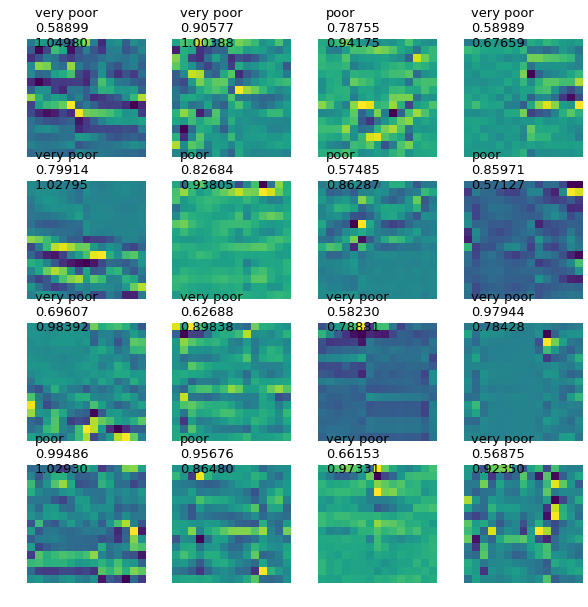

In [189]:
LABEL_NAMES = ['very poor', 'poor', 'better', 'ok', 'very ok', 'super ok', 'good', 'very good', 'super good', 'extraordinary']

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, orig_labels):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')

    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.5f' % confidence +  '\n%.5f' % orig_labels[i], fontsize=13)

  pyplot.gcf().set_size_inches(10, 10)

nr_ex = 32
start_from = randint(0, x_valid.shape[0]-nr_ex)
# start_from = 0
print("predicting for {} to {}".format(start_from, start_from+nr_ex))

# pred_y = model.predict(x_valid[start_from:start_from+nr_ex])

# max_pred = [np.argmax(y) for y in pred_y]
# print(max_pred)
# print(y_valid_oh[start_from:start_from+nr_ex])

plot_predictions(np.squeeze(x_valid[start_from:start_from+16]), model.predict(x_valid[start_from:start_from+16]), y_valid[start_from:start_from+16])